# Part2:Bonus Part

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

import json
with open('countries.json','r') as f:
    countries_dict = json.load(f)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'


from matplotlib.pylab import style
style.use('ggplot')

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf

In [42]:
df = pd.read_csv('data.csv',parse_dates=['Date'],index_col = 0)[['Track Name','Artist','Streams','Date','Region']]
df.dropna(inplace=True)

### 1. Number of days that the top 10 songs stay at the top 10.

In [131]:
# 按照 "Track Name" 分组，计算每个track的Streams总数
tracks_Streams = df.groupby('Track Name')['Streams'].sum().reset_index()

# 按照 Streams总数对于tracks进行降序排列，显示前十
top10_tracks = tracks_Streams.sort_values(by='Streams',ascending=False).head(10).reset_index()
top10_tracks.index = range(1,11)

<AxesSubplot:xlabel='top10_days', ylabel='Track Name'>

Text(0.5, 0, 'Track Name')

Text(0, 0.5, 'Number of days in top 10')

Text(0.5, 1.0, 'Top 10 tracks by days in top 10')

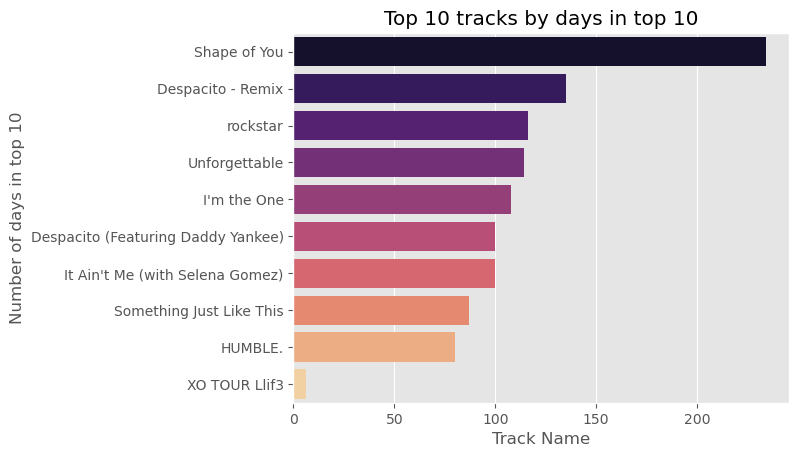

In [132]:
#按照Streams的总数，对每个日期中的tracks进行排名
Stream_eachDate['Ranking'] = Stream_eachDate.groupby('Date')['Streams'].rank(method='min',ascending=False)

Stream_top10_eachDate = Stream_eachDate[Stream_eachDate['Ranking'] <= 10]

top10_tracks_top10days = top10_tracks.copy()

for track in top10_tracks['Track Name']:
    count_days = Stream_top10_eachDate[Stream_top10_eachDate['Track Name']==track].shape[0]
    top10_tracks_top10days.loc[top10_tracks_top10days['Track Name'] == track, 'top10_days'] = count_days
    
top10_tracks_top10days = top10_tracks_top10days.sort_values(by='top10_days', ascending=False)


sns.barplot(x='top10_days', y='Track Name', data=top10_tracks_top10days, palette='magma')
plt.xlabel('Track Name')
plt.ylabel('Number of days in top 10')
plt.title('Top 10 tracks by days in top 10')

plt.show()

### 3. Tracks shared by top 10 tracks of all the 5 continents

In [133]:
#将df中的'Region'列映射为对应国家的大洲（Continent）信息，并将映射结果保存在新添加的'Continent'列中
def map_continent(country_name):
    country_info = countries_dict.get(country_name.upper())
    if country_info:
        return country_info.get('continent')
    else:
        return None
    
df['Continent'] = df['Region'].map(map_continent)

In [134]:
#算出每个continent中的每个track的Stream总数
tracks_eachContinent = df.groupby(['Track Name','Continent'])['Streams'].sum().reset_index()

tracks_eachContinent['Ranking'] = tracks_eachContinent.groupby('Continent')['Streams'].rank(method='min',ascending=False)

tracks_top10_eachContinent = tracks_eachContinent[tracks_eachContinent['Ranking'] <= 10]
tracks_top10_eachContinent.index = range(1,51)

shared_tracks = []
for track in tracks_top10_eachContinent['Track Name'].unique():
    if tracks_top10_eachContinent['Continent'][tracks_top10_eachContinent['Track Name']==track].nunique() == 5:
        shared_tracks.append(track)
print("The tracks shared by all top 10 tracks of all the 5 continents are:\n", shared_tracks)

The tracks shared by all top 10 tracks of all the 5 continents are:
 ['Despacito - Remix', 'Shape of You']


<AxesSubplot:xlabel='Track Name', ylabel='Streams'>

Text(0.5, 0, 'Shared tracks')

Text(0, 0.5, 'Number of streams')

Text(0.5, 1.05, 'The tracks shared by top 10 tracks of all the 5 continents')

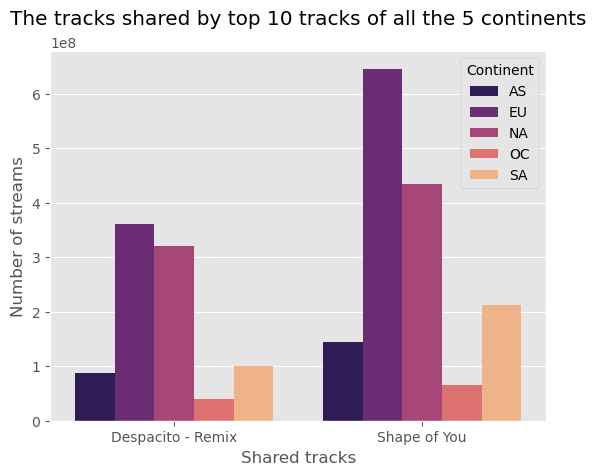

In [135]:
tracks_top10_eachContinent_2 = tracks_top10_eachContinent[tracks_top10_eachContinent['Track Name'].isin(shared_tracks)]

sns.barplot(x='Track Name', y='Streams', data=tracks_top10_eachContinent_2, palette='magma',hue = 'Continent')
plt.xlabel('Shared tracks')
plt.ylabel('Number of streams')
plt.title('The tracks shared by top 10 tracks of all the 5 continents',y = 1.05)
plt.show()

### Forecast the future number of streams for the top-ranked track using a seasonal ARIMA model.

The result shows that Shape of You has the highest total number of streams, so I will choose this track for prediction.

<Figure size 800x500 with 0 Axes>

<AxesSubplot:xlabel='Date', ylabel='Streams'>

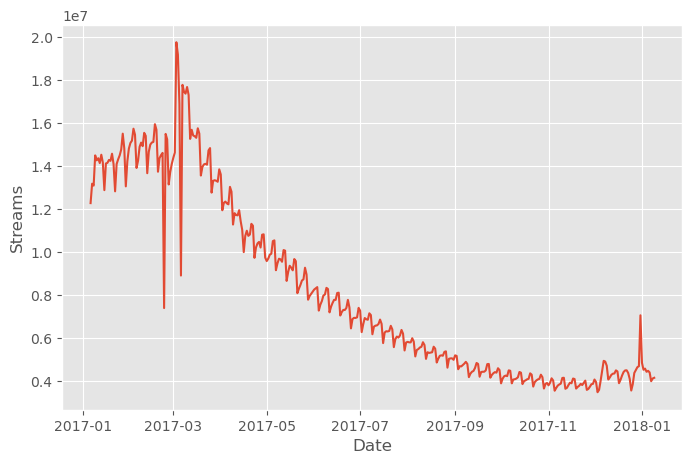

In [23]:
Stream_eachDate = df.groupby(['Date','Track Name','Artist'])['Streams'].sum().reset_index()
Shape_of_you = Stream_eachDate[(Stream_eachDate['Track Name'] == 'Shape of You')&(Stream_eachDate['Artist'] == 'Ed Sheeran')]
plt.figure(figsize = (8,5))
sns.lineplot(data = Shape_of_you, x = 'Date', y = 'Streams')
plt.show()

In [24]:
Shape_of_you.set_index('Date', inplace=True)
Streams = Shape_of_you['Streams']
Streams = Streams.to_frame()

#P = 0.6566100290740314 > 0.05，原始数列为非平稳序列
print(f"adfuller: {ADF(Streams)[1]}")

adfuller: 0.6566100290740314


Text(0.5, 1.0, 'diff1 Autocorrelation Plots')

/Users/suisui/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0.5, 1.0, 'diff1 Partial Autocorrelation Plots')

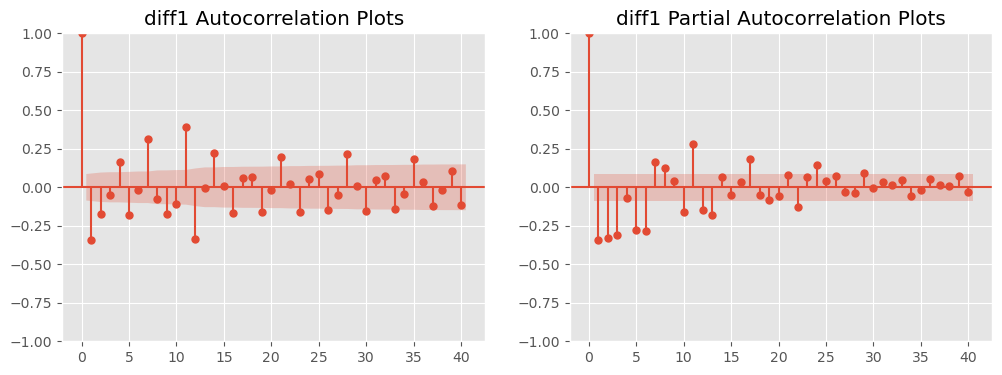

adfuller: 0.0002565287089173727


In [25]:
#一阶差分
d1_Streams = Streams.diff(periods = 1).dropna(inplace = False)

f= plt.figure(figsize = (12,4))
ax1= f.add_subplot(121)
f = plot_acf(d1_Streams, lags=40, ax=ax1, alpha = 0.1)
ax1.set_title('diff1 Autocorrelation Plots')
ax2 = f.add_subplot(122)
f = plot_pacf(d1_Streams, lags=40, ax=ax2, alpha = 0.1)
ax2.set_title('diff1 Partial Autocorrelation Plots')
plt.show()

#p < 0.05,一阶差分序列为平稳序列
print(f"adfuller: {ADF(d1_Streams)[1]}")

Text(0.5, 1.0, 'Week + Lag1 Autocorrelation Plots')

Text(0.5, 1.0, 'Week + Lag1 Partial Autocorrelation Plots')

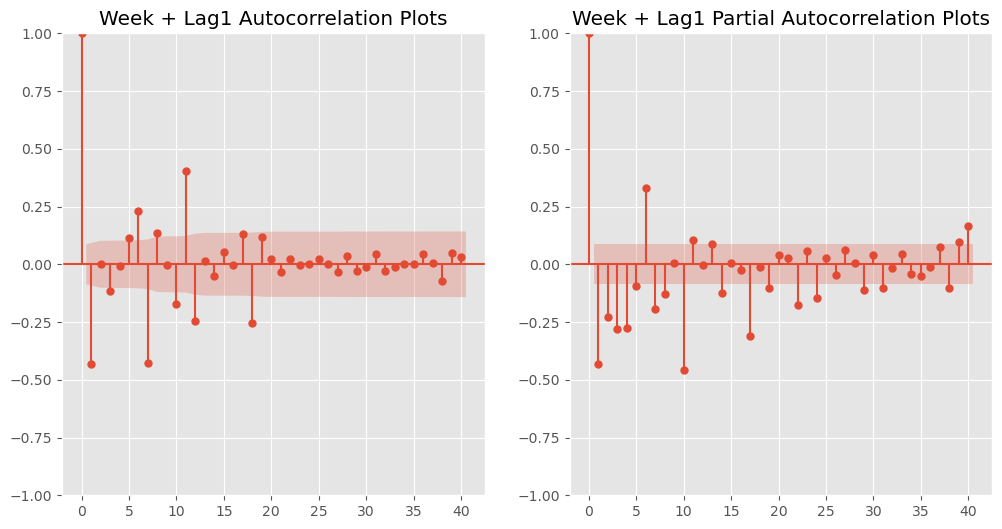

In [30]:
#季节性差分Seasonal difference
season_d1_Streams = d1_Streams.diff(periods = 7).dropna(inplace = False)
f= plt.figure(figsize = (12,6))
ax1= f.add_subplot(121)
f = plot_acf(season_d1_Streams, lags=40, ax=ax1, alpha = 0.1)
ax1.set_title('Week + Lag1 Autocorrelation Plots')
ax2 = f.add_subplot(122)
f = plot_pacf(season_d1_Streams, lags=40, ax=ax2, alpha = 0.1)
ax2.set_title('Week + Lag1 Partial Autocorrelation Plots')
plt.show()

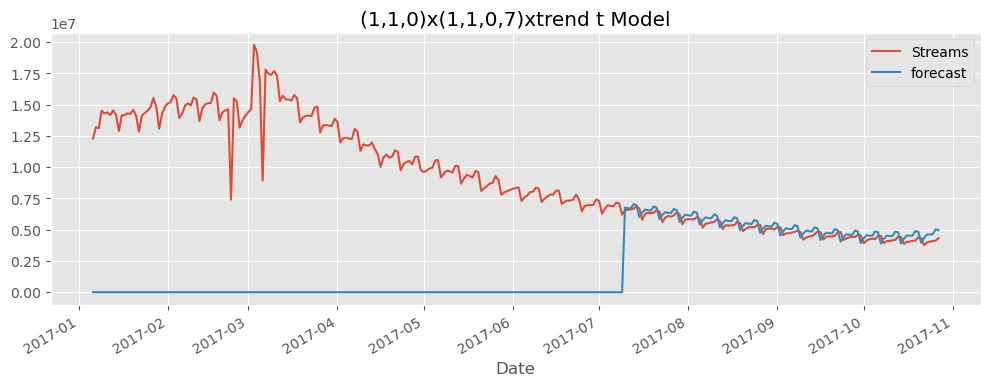

In [33]:
import warnings
warnings.filterwarnings('ignore')

#函数，获得X_train(80%), X_test(20%)
def get_X(track):
    nrows = track.shape[0]
    num_train = int(nrows * 0.8)
    X_train, X_test = track.iloc[np.arange(0,num_train),:], track.iloc[np.arange(num_train, nrows),:]
    return X_train, X_test, (nrows, num_train)

#函数，输出X_train拟合
def mdl_shape(mdl, row_info, name = '(1,1,0)x(1,1,0,7)xtrend t Model',exog = None, portion = 0.5):
    nrows, num_train = row_info
    result = mdl.fit(disp=False)
    forecast = result.predict(start = int(nrows*portion), end = num_train, dynamic = True, exog = exog)
    X_train['forecast'] = np.hstack([np.zeros((int(nrows*portion)-1)), forecast.values])
    f,ax = plt.subplots(1,1,figsize = (12,4))
    X_train[['Streams','forecast']].plot(ax = ax)
    ax.set_title(name)
    plt.show()
    
X_train, X_test,row_info = get_X(Streams)

#Modl
mdl1 = SARIMAX(X_train, trend = [1,0,0,1], order=(1,1,0), seasonal_order=(1,1,0,7))
mdl_shape(mdl1,row_info)

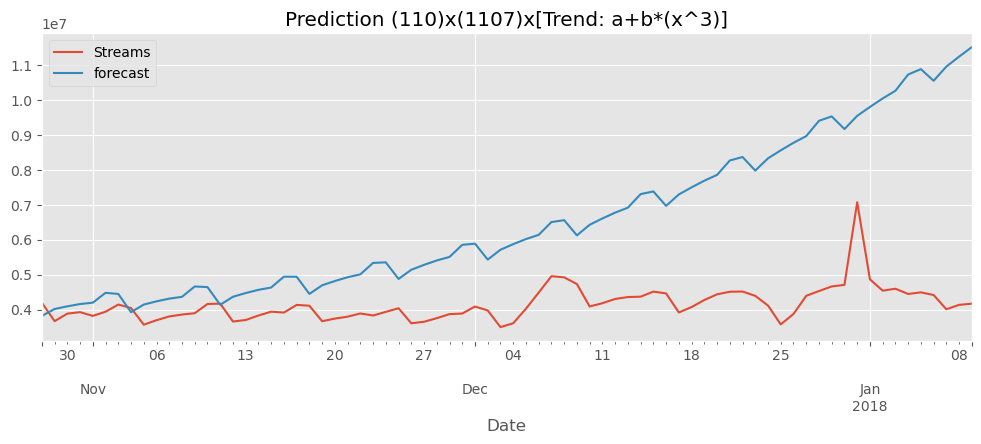

In [40]:
#函数，输出X_test拟合
def prediction_mdl(mdl,row_info, X_test, name = '', exog = None):
    nrows, num_train = row_info
    result = mdl.fit(disp=False)

    forecast = result.predict(start = num_train-1, end = nrows, dynamic = True, exog = exog)
    X_test['forecast'] = forecast[2:].values

    f,ax = plt.subplots(1,1,figsize = (12,4))
    X_test[['Streams','forecast']].plot(ax = ax)
    ax.set_title(name)
    plt.show()

prediction_mdl(mdl1, row_info, X_test, name = 'Prediction (110)x(1107)x[Trend: a+b*(x^3)]')

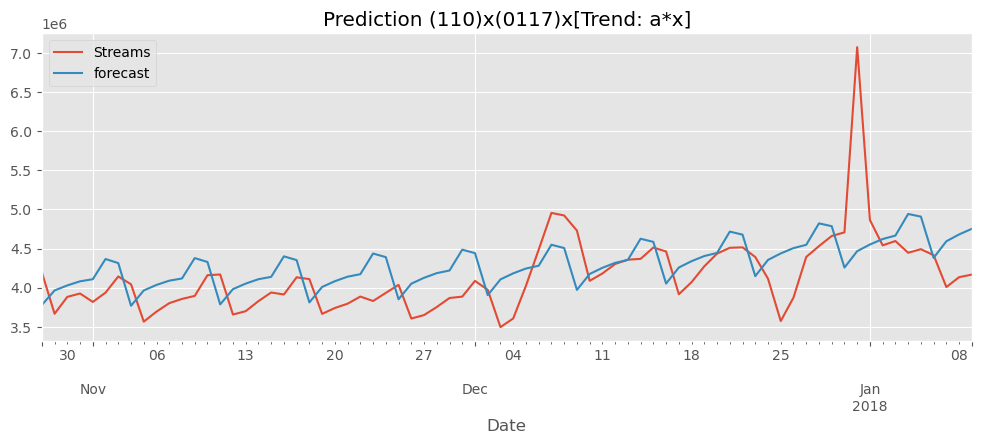

In [41]:
#model2
mdl2 = SARIMAX(X_train, trend = [0,1,0,0], order=(1,1,0), seasonal_order=(1,1,0,7))
prediction_mdl(mdl2, row_info, X_test, name = 'Prediction (110)x(0117)x[Trend: a*x]')

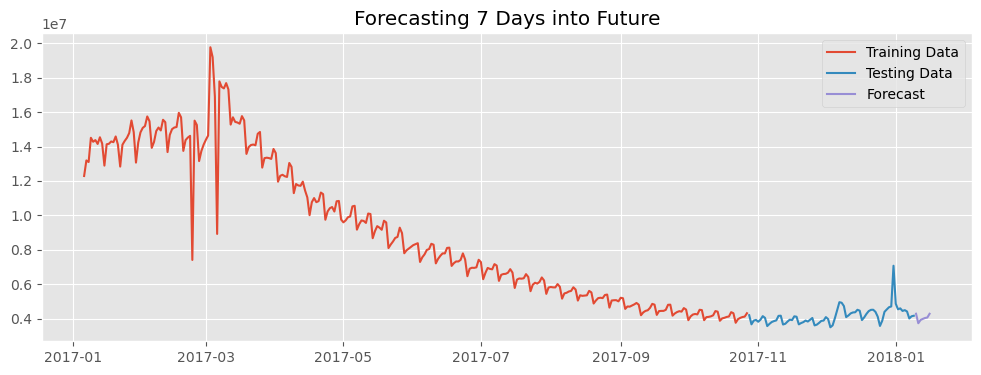

In [39]:
#函数，预测未来streams数据
def forecast_future(mdl, prediction_start_date, forecast_days, exog=None):
    # 得到 SARIMAX 模型的预测结果
    result = mdl.fit(disp=False)
    forecast = result.forecast(steps=forecast_days, exog=exog).tolist()
    
    # 创建日期范围
    last_date = pd.to_datetime(prediction_start_date, format='%Y-%m-%d')
    date_range = pd.date_range(start=last_date, periods=forecast_days + 1, freq='D')[1:]
    
    # 创建新的数据框来存储预测结果
    df_forecast = pd.DataFrame(forecast, index=date_range, columns=['forecast'])
    
    # 绘制预测结果和原始数据
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(X_train.index, X_train['Streams'], label='Training Data')
    ax.plot(X_test.index, X_test['Streams'], label='Testing Data')
    ax.plot(df_forecast.index, df_forecast['forecast'], label='Forecast')
    ax.legend()
    ax.set_title('Forecasting {} Days into Future'.format(forecast_days))
    plt.show()
    

forecast_future(mdl2,'2018-01-09',7,exog=None)